In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE reimplementation

For a 1D GP

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update({ # so we can use the definition of n to define x
    
    "x": jnp.arange(0, 1, 1/args["n"]),

    # VAE configuration
    "hidden_dim1": 35,
    "hidden_dim2": 32,
    "latent_dim": 30,
    "vae_var": 0.1,

    # learning
    "num_epochs": 50,
    "learning_rate": 1.0e-3,
    "batch_size": 100,
    "train_num_batches": 1000,
    "test_num_batches": 1000,

    # MCMC parameters
    "num_warmup": 1000,
    "num_samples": 1000,
    "thinning": 1,
    "num_chains": 3,

    "pretrained_vae": False


})

rng_key, _ = random.split(random.PRNGKey(4))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Examples of priors to encode

## SVI to learn VAE parameters

In [4]:
if not args["pretrained_vae"]:
    from reusable.gp import OneDGP

    # generate a complete set of training and test data
    train_predictive = Predictive(OneDGP, num_samples=args["train_num_batches"] * args["batch_size"])
    train_draws = train_predictive(rng_key, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]

    test_predictive = Predictive(OneDGP, num_samples=args["test_num_batches"] * args["batch_size"])
    test_draws = test_predictive(rng_key, x=args["x"], gp_kernel=args["gp_kernel"], jitter=1e-5)["y"]

    # batch these [note above ensures there are the right no. of elements]
    train_draws = jnp.split(train_draws, args["train_num_batches"], 0)
    test_draws = jnp.split(test_draws, args["test_num_batches"], 0)

    # u_draws = np.array(all_draws['u'])
    # gp_draws = np.array(all_draws['y'])

    # return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, u_draws)
    # train_ds = OneDGP(n_dataPoints=input_dim, n_samples=samples)
    # train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    # test_ds = GP1D(n_dataPoints=input_dim, n_samples=samples)
    # test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


In [5]:
from reusable.vae import VAE
from reusable.train_nn import TrainState, Metrics
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]  # initialize parameters by passing a template image
tx = optax.adam(args["learning_rate"])
state = TrainState.create(apply_fn=module.apply, params=params, tx=tx, metrics=Metrics.empty(), key = rng_key_init)


In [6]:
print(state.key)

[ 233325865 1391455902]


In [7]:
import optax
import jax


@jax.jit
def calculate_loss(y, reconstructed_y, mean, log_sd):
    # note doesn't divide by n
    RCL = jnp.sum(optax.l2_loss(reconstructed_y, y))  # change this to log-likelihood
    KLD = -0.5 * jnp.sum(1 + log_sd - jnp.power(mean, 2) - jnp.exp(log_sd))

    return RCL + KLD


@jax.jit
def compute_metrics(*, state: TrainState, batch):
    output = state.apply_fn({"params": state.params}, batch)
    loss = calculate_loss(*output)
    metric_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state


In [8]:
@jax.jit
def training_step(state: TrainState, batch):
    # note train_key is fixed for all iterations, we vary it here:
    current_train_key = jax.random.fold_in(key=state.key, data=state.step)


    def loss_fn(params):
        """A function, only of the parameters, that provides the loss on this given batch"""

        # will call the module with the batch
        outputs = state.apply_fn({'params': params}, batch, training=True, rngs={"train_latent_dist": current_train_key}) # batch will contain just the function values
        loss = calculate_loss(*outputs)
        
        return loss
    
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads) # increments state.step, so rng key fold_in does change
    return state


In [9]:
if not args["pretrained_vae"]:
    start = time.time()
    metrics_history = {'train_loss': [],
                   'train_accuracy': [],
                   'test_loss': [],
                   'test_accuracy': []}



    for i in range(args["num_epochs"]):
        # note this is a different indexing scheme to the Flax tutorial


        for j in range(args["train_num_batches"]):

            # Run optimization steps over training batches and compute batch metrics
            state = training_step(state, train_draws[j]) # get updated train state (which contains the updated parameters)
            state = compute_metrics(state=state, batch=train_draws[j]) # aggregate batch metrics



        for metric, value in state.metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value) # record metrics

        state = state.replace(metrics=state.metrics.empty()) # reset train_metrics for next training epoch
            
        test_state = state # make a new copy, so testing doesn't interfere
        for test_batch in test_draws:
            test_state = compute_metrics(state=test_state, batch=test_batch)

        for metric,value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)

        if i % 10 ==0:
            print(f"train epoch: {(i+1) }, "
                f"loss: {metrics_history['train_loss'][-1]}, "
                #f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
                )
            print(f"test epoch: {(i+1)}, "
                f"loss: {metrics_history['test_loss'][-1]}, "
                #f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
                )
    print(f"Done, in {time.time()-start}s ")

train epoch: 1, loss: 2883.818115234375, 
test epoch: 1, loss: 2584.57666015625, 
train epoch: 11, loss: 1178.02783203125, 
test epoch: 11, loss: 1221.6619873046875, 
train epoch: 21, loss: 1164.4305419921875, 
test epoch: 21, loss: 1192.5311279296875, 
train epoch: 31, loss: 1157.171142578125, 
test epoch: 31, loss: 1154.640625, 
train epoch: 41, loss: 1066.900390625, 
test epoch: 41, loss: 1049.2000732421875, 
Done, in 56.25477910041809s 


### Training progress

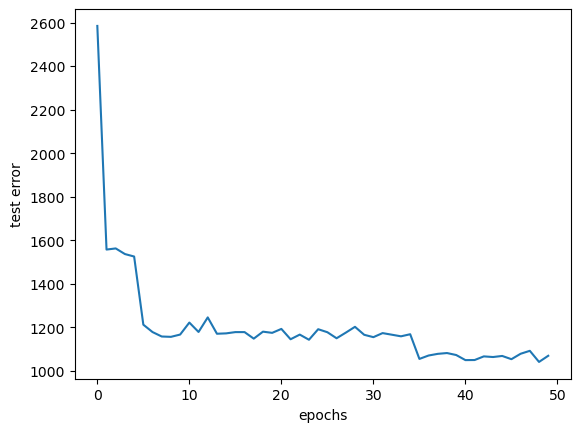

In [10]:
if not args["pretrained_vae"]:
    import matplotlib.pyplot as plt

    plt.figure()
    plt.plot(jnp.arange(len(metrics_history["test_loss"])), metrics_history["test_loss"], label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("test error")
    plt.show()

In [11]:
from flax.core.frozen_dict import freeze

if not args["pretrained_vae"]:
    decoder_params = state.params["VAE_Decoder_0"]
    #print(decoder_params)
    decoder_params = freeze({"params": decoder_params})
    args["decoder_params"] = decoder_params
    with open(f'learnt_models/02_decoder_1d_n{args["n"]}', 'wb') as file:
       file.write(serialization.to_bytes(decoder_params))

In [12]:
# TODO: test this!!!
if args["pretrained_vae"]:
    from reusable.vae import VAE_Decoder
    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"], conditional=False)
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
    with open(f'learnt_models/01_decoder_1d_n{args["n"]}', 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

## Demonstrations

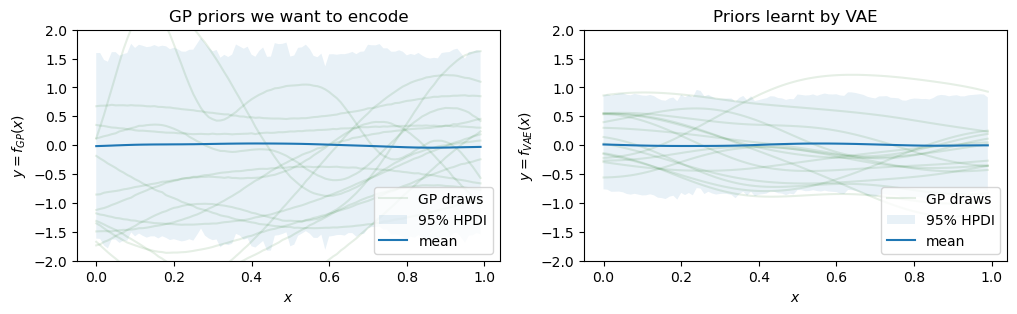

In [13]:
from reusable.vae import vae_sample
from plotting.plots import compare_draws
rng_key, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', save_path="gen_plots/01_prior_comp.png")


# Inference

In [14]:
import os


def run_mcmc(rng_key, model_mcmc, y_obs, obs_idx, verbose=False):
    start = time.time()

    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model_mcmc, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    mcmc.run(
        rng_key,
        args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["n"],
        args["decoder_params"],
        y=y_obs,
        obs_idx=obs_idx,
    )
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", time.time() - start)

    return mcmc.get_samples()


In [15]:
from reusable.vae import vae_mcmc

rng_key_ground_truth = random.PRNGKey(
    1
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(OneDGP, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"], noise=True
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T


x_obs_lst = []
y_obs_lst = []
predictions_lst = []

obs_idx_lst = [[22, 50], [16, 33, 57, 96], [8, 24, 45, 61, 77, 84]]


for i in range(len(obs_idx_lst)):
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = ground_truth_y_draw[obs_idx, 0]
    x_obs = args["x"][obs_idx]

    rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

    # inference
    mcmc_samples = run_mcmc(rng_key_post, vae_mcmc, y_obs, obs_idx)
    # hidden_dim1, hidden_dim2, latent_dim, out_dim, decoder_params
    predictive = Predictive(vae_mcmc, mcmc_samples)
    predictions = predictive(
        rng_key_pred,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]

    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)


prior_predictive = Predictive(vae_mcmc, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior,  hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"])["y_pred"]

/tmp/ipykernel_13568/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1013.19it/s, 63 steps of size 4.99e-02. acc. prob=0.69] 



MCMC elapsed time: 10.471148014068604


/tmp/ipykernel_13568/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:02<00:00, 991.42it/s, 127 steps of size 3.75e-02. acc. prob=0.83] 



MCMC elapsed time: 8.600632667541504


/tmp/ipykernel_13568/3108940662.py:9: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1010.81it/s, 127 steps of size 5.00e-02. acc. prob=0.54]



MCMC elapsed time: 8.977088689804077


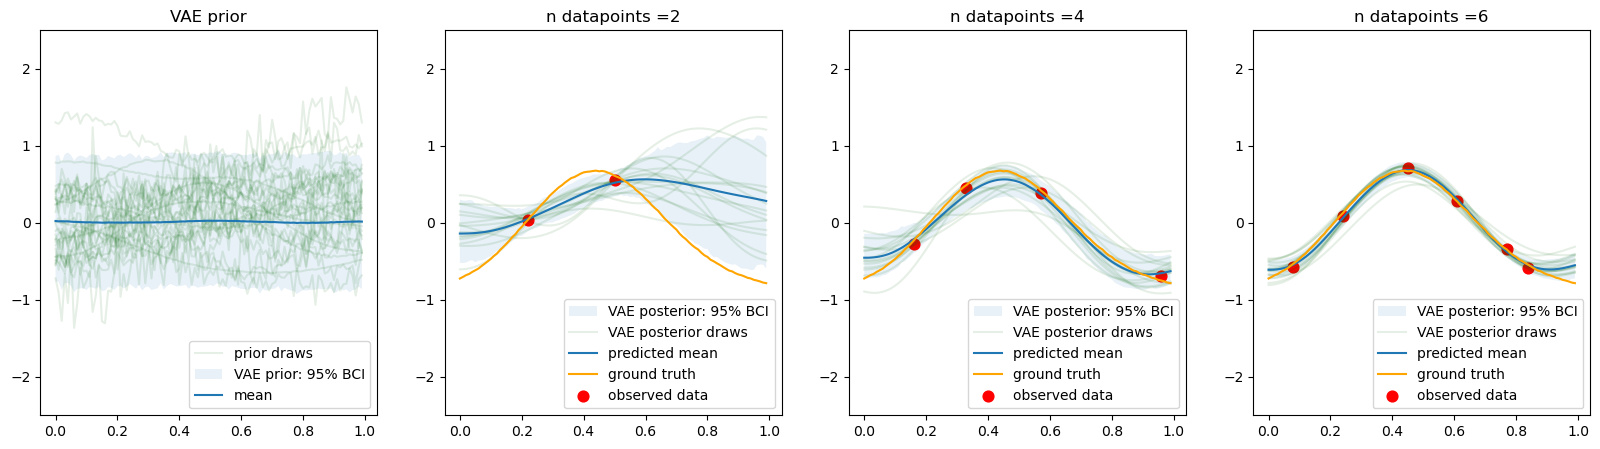

In [18]:
from plotting.plots import compare_inference_steps


compare_inference_steps(args["x"], ground_truth, x_obs_lst, y_obs_lst, prior_predictions, predictions_lst, title="VAE", save_path="gen_plots/02_inference_steps.png")

## Covariance matrices

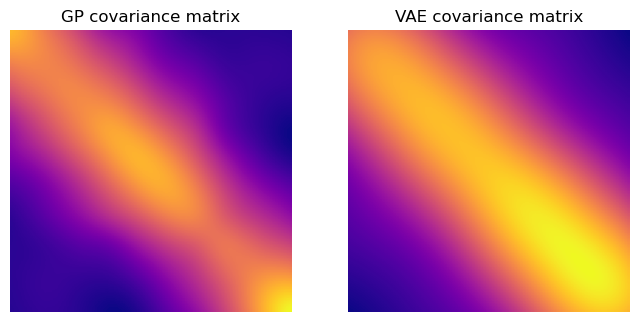

In [19]:
from plotting.plots import plot_cov_mat
import matplotlib.pyplot as plt

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

gp_predictive = Predictive(OneDGP, num_samples=100)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']
gp_draws = gp_draws[~jnp.isnan(gp_draws).any(axis=1), :]

vae_predictive = Predictive(vae_sample, num_samples=100)

vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))

plot_cov_mat(gp_draws, "GP covariance matrix", axs[0])
plot_cov_mat(vae_draws, "VAE covariance matrix", axs[1])


